In [1]:
!pip install python-louvain


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install pydot


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install graphviz 


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
import numpy as np
import math
from random import sample
import random
from IPython.display import display 
import statistics as stat
from collections import Counter
import community as community_louvain
from infomap import Infomap

try:
    import pydot
    from networkx.drawing.nx_pydot import graphviz_layout
except ImportError:
    raise ImportError("This example needs Graphviz and either "
                        "PyGraphviz or pydot")

### Step1. Read data to df

In [5]:
# Loading the dataset into a Pandas DataFrame
df_links=pd.read_csv('dataset/stack_network_links.csv')
df_nodes=pd.read_csv('dataset/stack_network_nodes.csv')

# display df and check null
display(df_links.head(5))
print('contains null =',df_links.isnull().values.any())
display(df_nodes.head(5))
print('contains null =',df_nodes.isnull().values.any())

,source,target,value
0,azure,.net,20.933192
1,sql-server,.net,32.322524
2,asp.net,.net,48.407030
3,entity-framework,.net,24.370903
4,wpf,.net,32.350925


contains null = False


,name,group,nodesize
0,html,6,272.45
1,css,6,341.17
2,hibernate,8,29.83
3,spring,8,52.84
4,ruby,3,70.14


contains null = False


### 2.1 number of nodes and edges

In [6]:
# num of nodes and edges
num_links=len(df_links)
num_nodes=len(df_nodes)

print('Number of nodes =',num_nodes)
print('Number of links =', num_links)

Number of nodes = 115
Number of links = 490


### 2.2 links['value'] and nodes['nodesize'] distribution

Text(0.5, 0, 'Node Size')

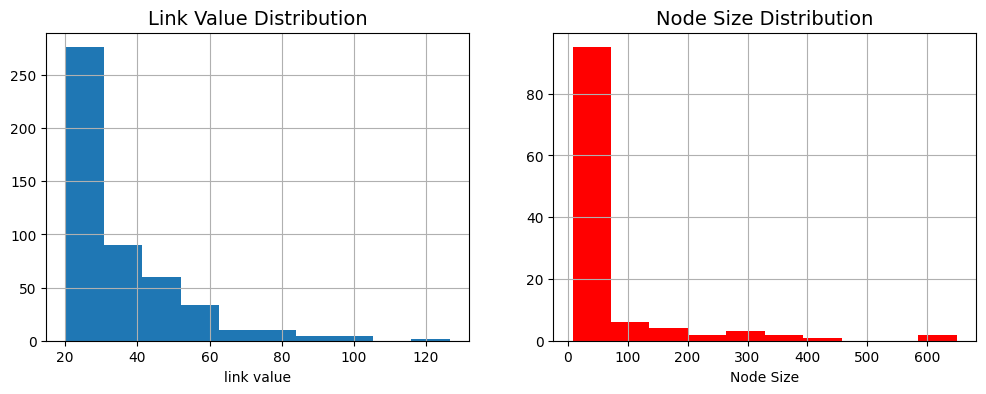

In [7]:
figsize=(12,4)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=figsize)
fontsize=14

plt.subplot(1, 2, 1)
ax1=df_links.value.hist()
ax1.set_title('Link Value Distribution',fontsize=fontsize)
ax1.set_xlabel('link value')
ax1.plot()

plt.subplot(1, 2, 2)
ax2=df_nodes.nodesize.hist(color='red')
ax2.set_title('Node Size Distribution',fontsize=fontsize)
ax2.set_xlabel('Node Size')

### 2.3 nodes['group'] distribution bar plot

In [8]:
group_count=df_nodes['group'].value_counts()

group_idx=group_count.index
group_idx=group_idx.astype(str)
group_cnt=group_count.values

print('group_idx:',group_idx)
print('group_cnt',group_cnt,'\n')
# print('Length check =',len(group_cnt)==len(group_idx))

group_idx: Index(['6', '2', '8', '3', '5', '1', '4', '9', '10', '14', '7', '12', '11',
       '13'],
      dtype='object')
group_cnt [23 18 12 11 11 10  8  6  4  3  3  2  2  2] 



In [9]:
# function for bar plot with numerical label
def bar_plt(figsize,title,width,x,y,xlabel,ylabel):
    fig, ax = plt.subplots(figsize=figsize)
    # set title
    ax.set_title(title,fontsize=14)
    # set x axis label location
    x_loc=np.arange(len(x))
    ax.set_xticks(x_loc)
    # height
    height=list(y)
    # bar rectangle
    rect = ax.bar(x, height, width,color='Lightgreen')
    # set x and y label
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    # set the text for each rect
    for j in range(len(x_loc)):
        ax.text(x_loc[j],height[j],str(height[j]),ha='center')
    

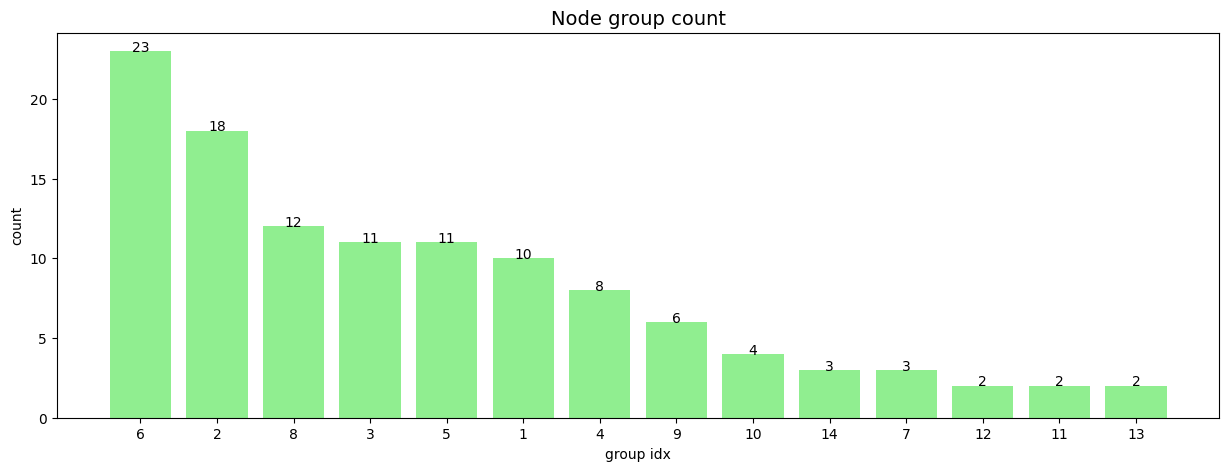

In [10]:
bar_plt(figsize=(15,5),
        title='Node group count',
        width=0.8,
        x=group_idx,
        y=group_cnt,
        xlabel='group idx',
        ylabel='count')

#### 2.3.1 Define a function return tags in group

In [11]:
# input group number, return tags
def tags_in_group(group_number):
    tags=df_nodes['name'].loc[df_nodes['group']==group_number]
    tags=list(tags)
    print('Number of tags in group',group_number,':',len(tags))
    return tags

In [12]:
largest_group=group_count.idxmax()
print('Largest group is: ',largest_group)

tags_in_group(6)

Largest group is:  6
Number of tags in group 6 : 23


['html',
 'css',
 'html5',
 'javascript',
 'jquery',
 'php',
 'mysql',
 'less',
 'sass',
 'ajax',
 'angularjs',
 'laravel',
 'json',
 'xml',
 'wordpress',
 'codeigniter',
 'twitter-bootstrap',
 'ionic-framework',
 'vue.js',
 'drupal',
 'bootstrap',
 'twitter-bootstrap-3',
 'photoshop']

#### 2.3.2 Def Input tags return belong group

In [13]:
def group_for_tag(tag):
    group=df_nodes['group'].loc[df_nodes['name']==tag].values
    group=group[0]
    group_size=len(df_nodes.loc[df_nodes['group']==group])
    
    print ('The tag',tag,'is in group: ',group)
    print ('group',group,'size: ',group_size)
    return group

In [14]:
group_for_tag('python')
group_for_tag('c++')
group_for_tag('mysql')

The tag python is in group:  1
group 1 size:  10
The tag c++ is in group:  1
group 1 size:  10
The tag mysql is in group:  6
group 6 size:  23


6

### Network analysis with community detection - louvain algorithm

In [15]:
# !pip install graphviz graphviz-devel

In [16]:
# get edges and weight
edges = df_links[['source', 'target']].values.tolist()
weights = [float(l) for l in df_links.value.values.tolist()]

In [17]:
# Make Graph and apply weight
G = nx.Graph(directed=True)
G.add_edges_from(edges)
for cnt, a in enumerate(G.edges(data=True)):
    G.edges[(a[0], a[1])]['weight'] = weights[cnt]

In [18]:
def simple_Infomap(G):
    """Infomap community detection"""
    # Create a mapping from string nodes to integer identifiers
    node_to_int = {node: i for i, node in enumerate(G.nodes())}
    int_to_node = {i: node for node, i in node_to_int.items()}

    # Running Infomap for community detection
    infomap = Infomap()
    for e in G.edges(data=True):
        node1, node2 = node_to_int[e[0]], node_to_int[e[1]]
        weight = float(e[2].get('weight', 1))  # Ensure weight is a float
        infomap.addLink(node1, node2, weight)

    infomap.run()

    # Extracting the community assignments
    infomap_communities = {int_to_node[node]: infomap.getModules()[node] for node in node_to_int.values()}

    max_k_w = []
    for com in set(infomap_communities.values()):
        list_nodes = [nodes for nodes in infomap_communities.keys() if infomap_communities[nodes] == com]
        max_k_w = max_k_w + [list_nodes]

    node_mapping = {}
    map_v = 0
    for node in G.nodes():
        node_mapping[node] = map_v
        map_v += 1

    community_num_group = len(max_k_w)
    color_list_community = [[] for i in range(len(G.nodes()))]

    # color
    for i in G.nodes():
        for j in range(community_num_group):
            if i in max_k_w[j]:
                color_list_community[node_mapping[i]] = j

    # Use graphviz_layout for better separation of communities
    pos = graphviz_layout(G)

    return G, pos, color_list_community, community_num_group, max_k_w


In [19]:
def simple_Louvain(G):
    """ Louvain method github basic example"""
    partition = community_louvain.best_partition(G)
    pos = graphviz_layout(G)
    
    max_k_w = []
    for com in set(partition.values()):
        list_nodes = [nodes for nodes in partition.keys()
                      if partition[nodes] == com]
        max_k_w = max_k_w + [list_nodes]

    
    node_mapping = {}
    map_v = 0
    for node in G.nodes():
        node_mapping[node] = map_v
        map_v += 1

    community_num_group = len(max_k_w)
    color_list_community = [[] for i in range(len(G.nodes()))]
    
    # color
    for i in G.nodes():
        for j in range(community_num_group):
            if i in max_k_w[j]:
                color_list_community[node_mapping[i]] = j
    
    return G, pos, color_list_community, community_num_group, max_k_w

In [20]:
# Running Infomap & Louvian and visualizing
G, pos, infomap_color_list_community, infomap_community_num_group, max_k_w = simple_Infomap(G)
G, pos, louvian_color_list_community, louvian_community_num_group, max_k_w = simple_Louvain(G)

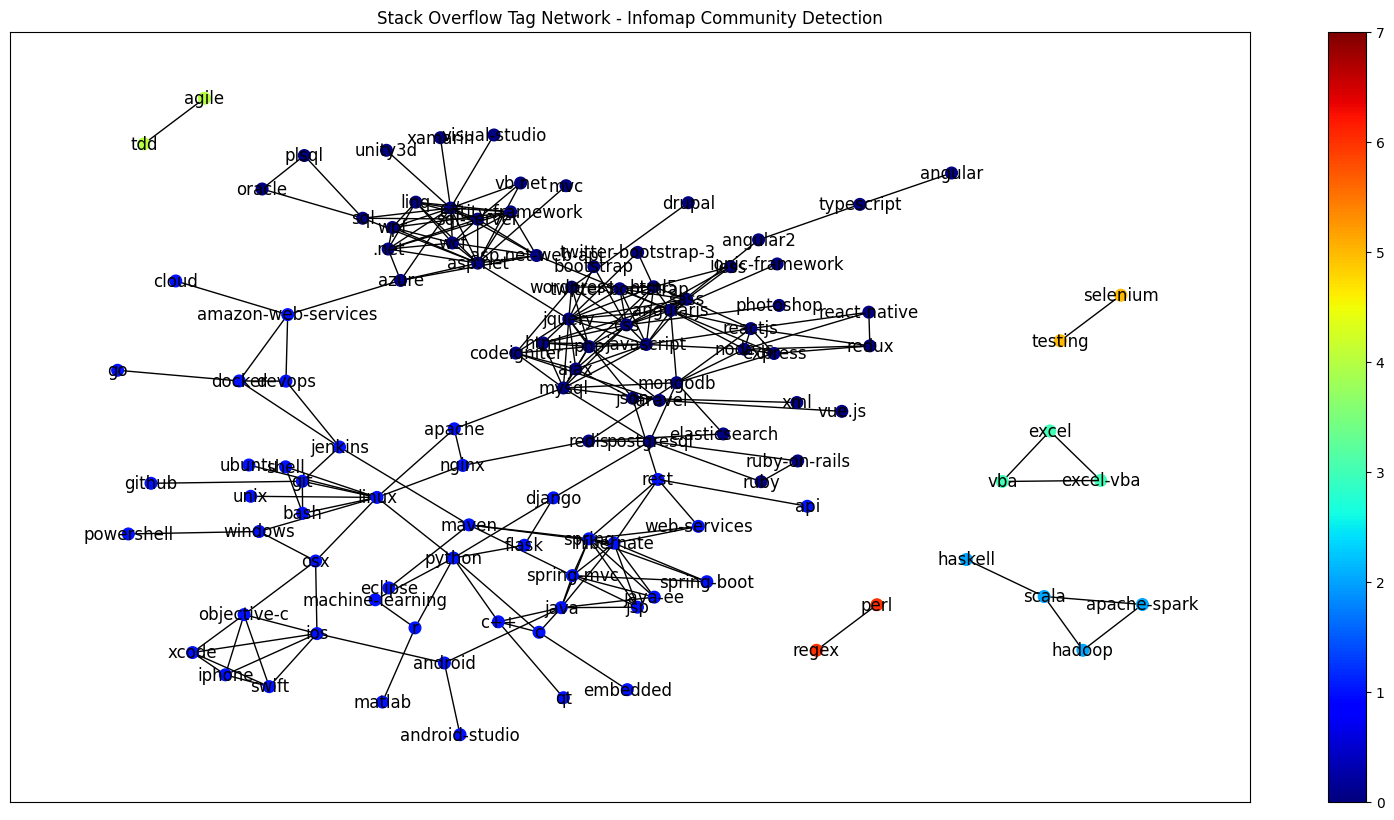

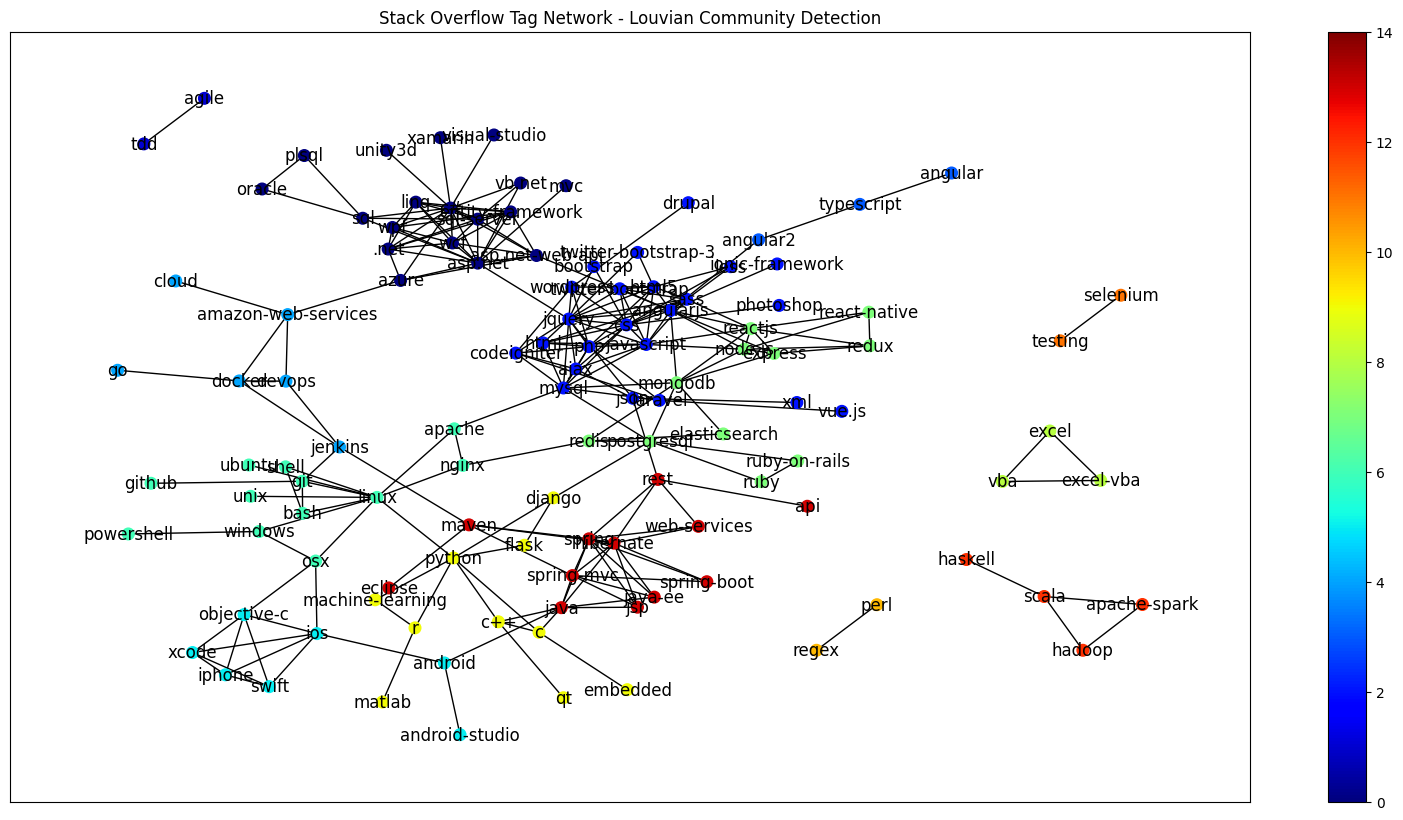

Infomap detected 7 communities.
Louvain method detected 14 communities.


In [21]:
# Visualizing the network with nodes colored by community
edges = G.edges()
node_size = 70

# Visualizing Infomap communities
fig = plt.figure(figsize=(20, 10))
im = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=infomap_color_list_community, cmap='jet', vmin=0, vmax=infomap_community_num_group)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")
plt.xticks([])
plt.yticks([])
plt.colorbar(im)
plt.title('Stack Overflow Tag Network - Infomap Community Detection')
plt.show(block=False)

# Visualizing Louvain communities
fig = plt.figure(figsize=(20, 10))
im = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=louvian_color_list_community, cmap='jet', vmin=0, vmax=louvian_community_num_group)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")
plt.xticks([])
plt.yticks([])
plt.colorbar(im)
plt.title('Stack Overflow Tag Network - Louvian Community Detection')
plt.show(block=False)

# Compare community detection results
print("Infomap detected", len(set(infomap_color_list_community)), "communities.")
print("Louvain method detected", len(set(louvian_color_list_community)), "communities.")


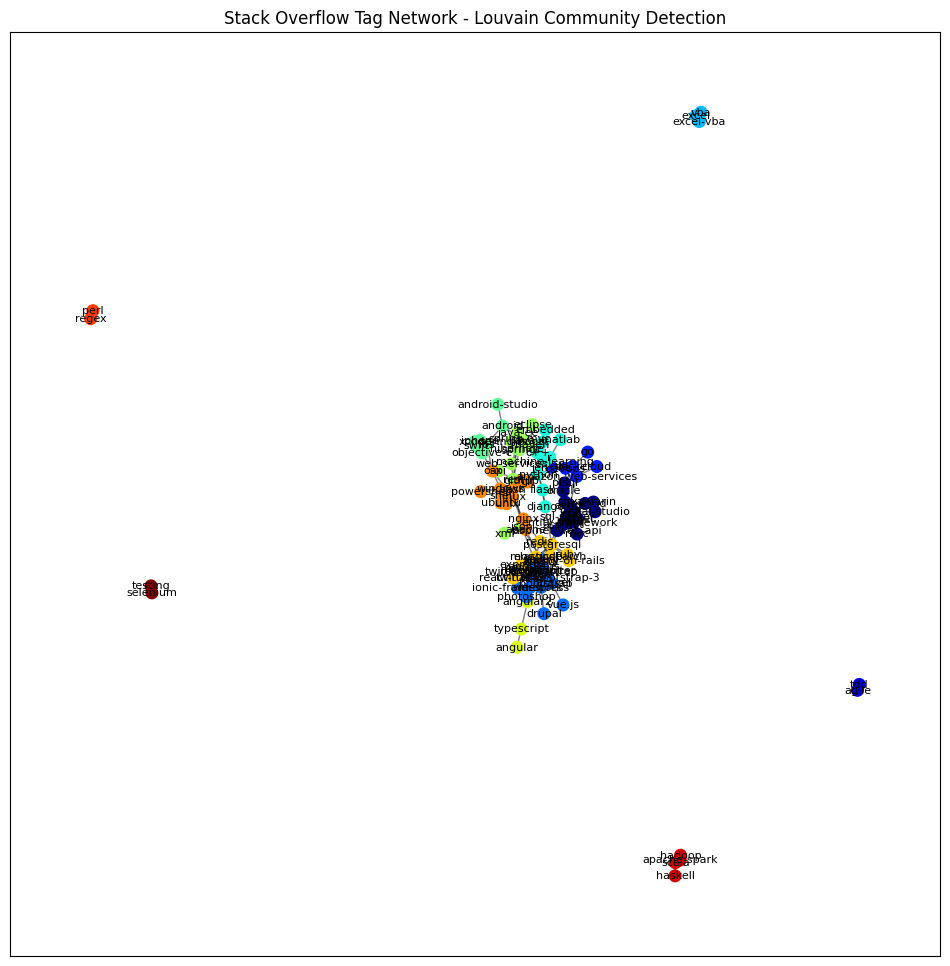

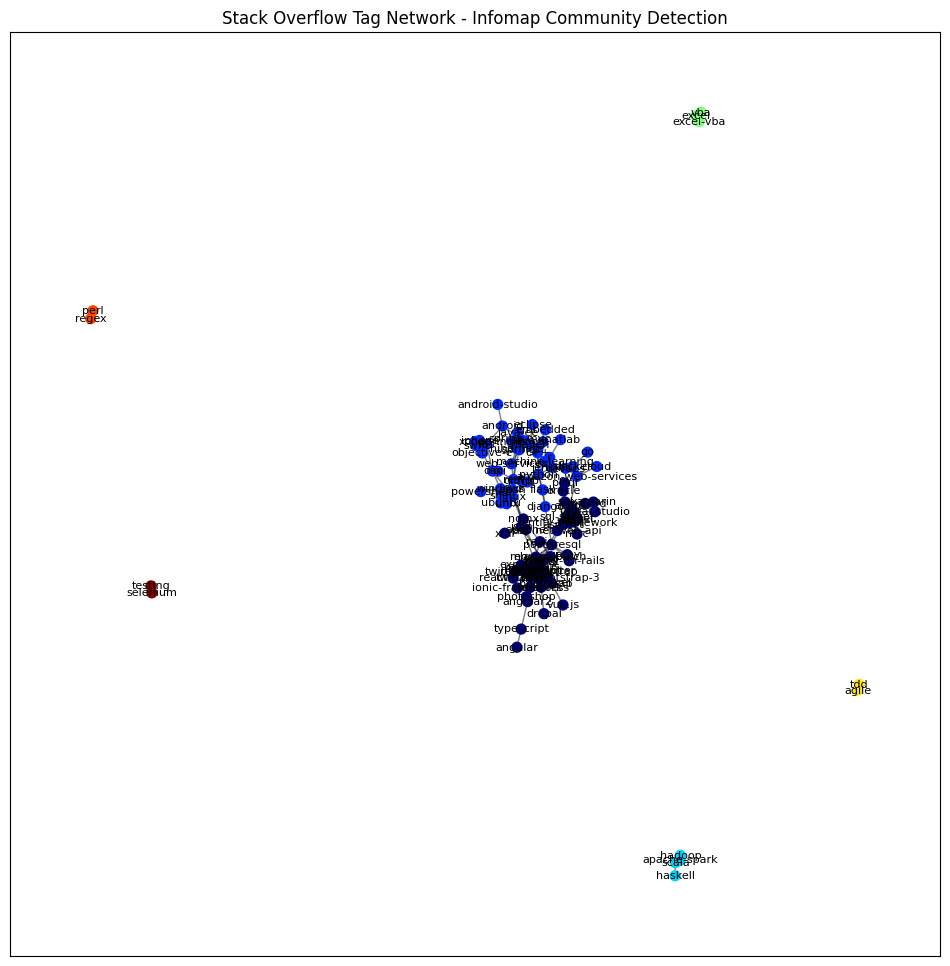

Louvain method detected 14 communities.
Infomap detected 7 communities.


In [ ]:
# Importing necessary libraries for Louvain method
import community as community_louvain

# Running Louvain for community detection
partition = community_louvain.best_partition(G)

# Importing necessary libraries for Infomap
from infomap import Infomap

# Create a mapping from string nodes to integer identifiers
node_to_int = {node: i for i, node in enumerate(G.nodes())}
int_to_node = {i: node for node, i in node_to_int.items()}

# Running Infomap for community detection
infomap = Infomap()
for e in G.edges(data=True):
    node1, node2 = node_to_int[e[0]], node_to_int[e[1]]
    weight = float(e[2].get('Weight', 1))  # Ensure weight is a float
    infomap.addLink(node1, node2, weight)

infomap.run()

# Extracting the community assignments
infomap_communities = {int_to_node[node]: infomap.getModules()[node] for node in node_to_int.values()}

# Adding Infomap community results to the graph
nx.set_node_attributes(G, infomap_communities, 'infomap_community')

# Comparing Infomap and Louvain community detection results
louvain_communities = list(partition.values())
infomap_communities_list = list(infomap_communities.values())

# Visualizing Louvain communities
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_color=louvain_communities, cmap=plt.cm.jet, node_size=70)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title('Stack Overflow Tag Network - Louvain Community Detection')
plt.show()

# Visualizing Infomap communities
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_color=infomap_communities_list, cmap=plt.cm.jet, node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title('Stack Overflow Tag Network - Infomap Community Detection')
plt.show()

# Compare community detection results
print("Louvain method detected", len(set(louvain_communities)), "communities.")
print("Infomap detected", len(set(infomap_communities_list)), "communities.")


In [ ]:
louvain_communities

[13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 1,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 7,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 7,
 8,
 8,
 8,
 3,
 3,
 9,
 9,
 3,
 3,
 9,
 9,
 13,
 3,
 10,
 10,
 10,
 11,
 11,
 11,
 7,
 7,
 13,
 13,
 13,
 10,
 10,
 10,
 3,
 4,
 4,
 4,
 4,
 13,
 13,
 13,
 4,
 3,
 3,
 3,
 3,
 3,
 0,
 4,
 4,
 9,
 0,
 3,
 7,
 7,
 9,
 9,
 2,
 2,
 2,
 9,
 10,
 11,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 3,
 6,
 6,
 6,
 6,
 6,
 7,
 3,
 10,
 10,
 10,
 4,
 4,
 4,
 9,
 13,
 13,
 5,
 5,
 9,
 9,
 10,
 12,
 12]